## Introduction to DINOv2

DINOv2 (Distillation of Knowledge with No Labels) is a self-supervised learning method developed by Meta AI Research.
It leverages Vision Transformers (ViTs) to learn robust visual features from unlabelled data, making it highly suitable for medical imaging tasks like echocardiograms.

**Usefulness in Echocardiogram Analysis**

Large Unlabelled Dataset: DINOv2 can effectively utilize a large unlabelled dataset of echocardiograms to learn meaningful representations.

Small Labelled Dataset: The small labelled dataset can be used to fine-tune the model, enhancing its performance on specific tasks such as disease detection or segmentation.

**Advantages Over Contrastive Learning**
- No Need for Negative Samples: Unlike contrastive learning, which requires negative samples to learn representations, DINOv2 does not need them. This simplifies the training process and reduces the risk of sampling bias.
- Better Feature Representation: DINOv2 provides more robust and generalizable features, which are crucial for medical imaging where variations in data can be significant.
- Scalability: DINOv2 scales better with larger datasets, making it more suitable for extensive unlabelled datasets.
  
### Methodology
#### Data Preparation:

Collect a large unlabelled dataset of echocardiograms.
Prepare a small labelled dataset for fine-tuning.
#### Model Training:

Self-Supervised Pretraining: Use DINOv2 to pretrain the model on the unlabelled dataset. This involves learning visual features directly from the images without any labels1.
Feature Extraction: Extract features from the pretrained model. These features are robust and can be used for various downstream tasks.
Fine-Tuning:

Fine-tune the pretrained model on the small labelled dataset. This step adapts the model to the specific task, such as classifying different heart conditions.
Evaluation:

Evaluate the model’s performance on a validation set to ensure it generalizes well to new data.
Compare the performance with models trained using contrastive learning to highlight the improvements.
DINOv2 Loss Function
Loss Function: DINOv2 uses a self-distillation loss function. The core idea is to train a student model to match the output distribution of a teacher model, which is also being trained simultaneously.
Formula: The loss function can be expressed as:

L=∑i=1NKL(pteacher(xi)∥pstudent(xi))
L=i=1∑N​KL(pteacher​(xi​)∥pstudent​(xi​))

where ( \text{KL} ) denotes the Kullback-Leibler divergence, ( p_{\text{teacher}} ) is the probability distribution output by the teacher model, and ( p_{\text{student}} ) is the probability distribution output by the student model.
Conclusion
DINOv2 offers a powerful solution for leveraging large unlabelled datasets, making it highly suitable for medical imaging tasks like echocardiogram analysis.
Its ability to learn robust features without the need for negative samples and its scalability make it a superior choice over contrastive learning methods.

## Loading dataset

We need to load the dataset from Google Cloud Storage and prepare it for training. We will modify the dataset class to handle multiple labels.

# Handling Patient Information in Medical Images without Distortion

In this script, we aim to preprocess medical images by removing sections containing patient information. The challenge is to remove this information without distorting the images, which can negatively impact the performance of machine learning models and clustering algorithms. To achieve this, we use a custom padding transform instead of cropping, which helps maintain the aspect ratio and integrity of the images.

## Key Steps:

1. **Custom Padding Transform**:
    - We define a `CustomPad` class that pads a specified area of the image with a constant value (e.g., black pixels).
    - This approach ensures that the images are not sheared or distorted, preserving their original aspect ratio.

2. **Data Augmentation Pipeline**:
    - We integrate the `CustomPad` transform into the data augmentation pipeline.
    - The pipeline includes additional transformations such as random horizontal flipping, resizing, converting to tensor, and normalization.

### Custom Padding Transform

The `CustomPad` class is designed to pad a specific region of the image. The region to be padded is defined by the coordinates (`x_min`, `y_min`, `x_max`, `y_max`). The padding value can be specified (default is 0, which corresponds to black pixels).


In [1]:
import io
import os
from google.cloud import storage
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader, random_split, Subset


import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report



os.environ["GCLOUD_PROJECT"] = "rhd-diagnosis"

# Set the environment variable for authentication
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "rhd-diagnosis-17affaa34749.json"


class GCPBucketDataset(Dataset):
    def __init__(self, bucket_name, prefix, csv_file, transform=None):
        self.bucket_name = bucket_name
        self.prefix = prefix
        self.transform = transform

        # Connect to Google Cloud Storage
        self.storage_client = storage.Client()
        self.bucket = self.storage_client.bucket(self.bucket_name)

        # Get list of files in the bucket
        self.file_paths = [blob.name for blob in self.bucket.list_blobs(prefix=self.prefix)]

        # Read labels from CSV file
        self.labels, self.num_classes = self._read_labels(csv_file)

    def _read_labels(self, csv_file):
        # Download the CSV file from the bucket
        blob = self.bucket.blob(csv_file)
        with blob.open("rb") as f:
            labels_df = pd.read_csv(f)
        
        # Convert to dictionary for quick lookup
        # Clean up condition labels by removing extra brackets
        labels_df['CONDITION'] = labels_df['CONDITION'].str.strip("[]").str.replace("'", "")

        labels_dict = dict(zip(labels_df['FILENAME'], 
                               zip(labels_df['VIEW-APP'], 
                                   labels_df['CONDITION'], 
                                   labels_df['SEVERITY'])))
        
        # Count unique classes
        num_classes = {
            'view': len(labels_df['VIEW-APP'].unique()),
            'condition': len(labels_df['CONDITION'].unique()),
            'severity': len(labels_df['SEVERITY'].unique())
        }
        
        # Print the number of unique classes
        print("Number of unique classes:")
        print(num_classes)

        # Print the actual unique values
        unique_values = {
            'view': labels_df['VIEW-APP'].unique(),
            'condition': labels_df['CONDITION'].unique(),
            'severity': labels_df['SEVERITY'].unique()
        }
        
        print("\nUnique values for each label type:")
        for label_type, values in unique_values.items():
            print(f"{label_type.capitalize()} labels: {values}")
        
        return labels_dict, num_classes

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        blob = self.bucket.blob(file_path)

        # Download the file from the bucket
        with blob.open("rb") as f:
            image = Image.open(io.BytesIO(f.read())).convert('RGB')

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        # Extract the filename from the file path
        filename = os.path.basename(file_path)

        # Get the labels for the image
        view_label, condition_label, severity_label = self.labels.get(filename, (-1, -1, -1))

        return image, (view_label, condition_label, severity_label)
    
    def get_num_classes(self):
        return self.num_classes   
    

# Example Usage
bucket_name = 'rhdiag'
labelled_prefix = 'supervised/annotated-final'  # Example: 'images/train'
unlabelled_prefix = 'unsupervised-videos/unlabelled-frames'
csv_file = 'supervised/sorted_file.csv'  # Path to the CSV file in the bucket


class CustomPad:
    def __init__(self, x_min, y_min, x_max, y_max, pad_value=0):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        self.pad_value = pad_value

    def __call__(self, image):
        # Convert to PIL Image if necessary
        if isinstance(image, torch.Tensor):
            image = F.to_pil_image(image)
        
        # Create a mask with the same size as the image
        mask = Image.new('L', image.size, 0)
        
        # Draw a rectangle on the mask where the padding should be applied
        draw = ImageDraw.Draw(mask)
        draw.rectangle([self.x_min, self.y_min, self.x_max, self.y_max], fill=255)
        
        # Apply the mask to the image
        image = Image.composite(image, Image.new('RGB', image.size, (self.pad_value, self.pad_value, self.pad_value)), mask)
        
        return image
# Data Augmentation
data_transforms = transforms.Compose([
    CustomPad(x_min=40, y_min=60, x_max=550, y_max=400, pad_value=0),
    #transforms.RandomResizedCrop(224),  # Adjust size as needed
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Dataset
labelled_dataset = GCPBucketDataset(bucket_name, labelled_prefix, csv_file, transform=data_transforms)
print(f'Total number of images in the labelled dataset: {len(labelled_dataset)}')

# Define the split ratio
train_ratio = 0.8
train_size = int(train_ratio * len(labelled_dataset))
val_size = len(labelled_dataset) - train_size


# Split the dataset
train_dataset, val_dataset = random_split(labelled_dataset, [train_size, val_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Create Dataset
unlabelled_dataset = GCPBucketDataset(bucket_name, unlabelled_prefix, csv_file, transform=data_transforms)
print(f'\nTotal number of images in the unlabeled dataset : {len(unlabelled_dataset)}')

# Use only a subset of the dataset
subset_size = 100  # Adjust the subset size as needed
indices = list(range(len(unlabelled_dataset)))
np.random.shuffle(indices)
subset_indices = indices[:subset_size]
subset_dataset = Subset(unlabelled_dataset, subset_indices)
print(f'\nTotal number of images in the subset of the unlabeled dataset : {len(subset_dataset)}')

# Create dataloaders
unlabelled_dataloader = DataLoader(subset_dataset, batch_size=16, shuffle=False)

Number of unique classes:
{'view': 3, 'condition': 7, 'severity': 3}

Unique values for each label type:
View labels: ['Parasternal long axis (PLAX)' 'Parasternal short axis(PSAX)'
 'Apical Four Chamber(A4C)']
Condition labels: ['Not Applicable' 'Aortic Valve Regurgitation' 'Mitral Valve Prolapse'
 'Aortic Valve Regurgitation, Pulmonary Valve Regurgitation'
 'Tricuspid Valve Regurgitation' 'Pulmonary Valve Regurgitation'
 'Mitral Valve Regurgitation']
Severity labels: ['Not Applicable' 'Borderline rhd' 'Definite rhd']
Total number of images in the labelled dataset: 2640
Number of unique classes:
{'view': 3, 'condition': 7, 'severity': 3}

Unique values for each label type:
View labels: ['Parasternal long axis (PLAX)' 'Parasternal short axis(PSAX)'
 'Apical Four Chamber(A4C)']
Condition labels: ['Not Applicable' 'Aortic Valve Regurgitation' 'Mitral Valve Prolapse'
 'Aortic Valve Regurgitation, Pulmonary Valve Regurgitation'
 'Tricuspid Valve Regurgitation' 'Pulmonary Valve Regurgitation

## Visualizing image samples

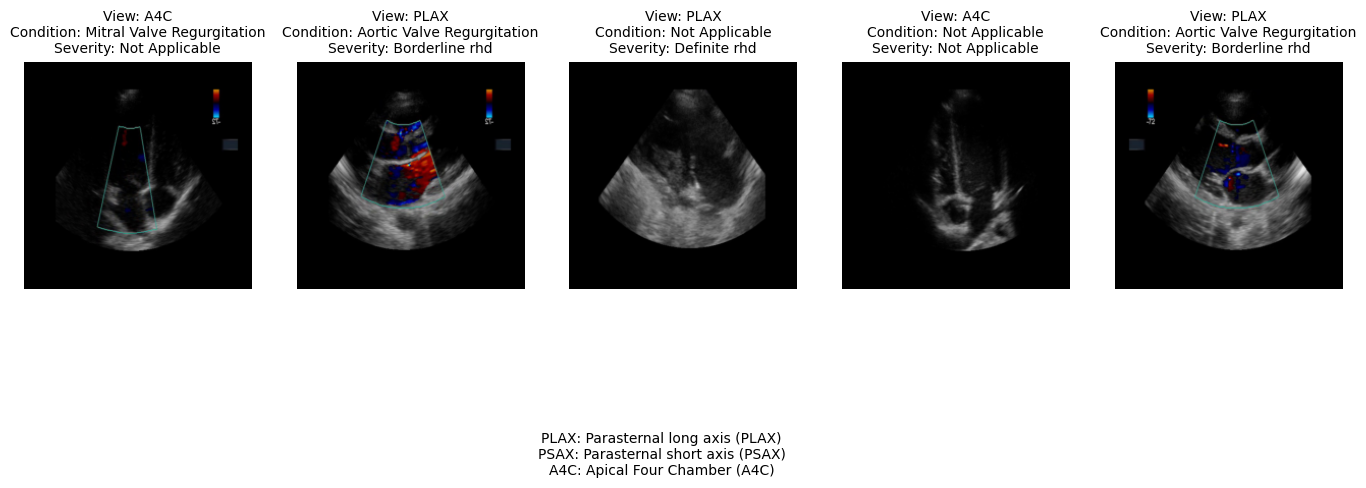

In [31]:
def visualize_samples(dataloader, num_samples=5, label_decoders=None, save_path=None):
    # Get a batch of images and labels
    images, labels = next(iter(dataloader))
    view_labels, condition_labels, severity_labels = labels
    
    # Decode labels if decoders are provided
    if label_decoders:
        view_labels = [label_decoders['view'].get(label, 'Unknown') for label in view_labels]
        condition_labels = [label_decoders['condition'].get(label, 'Unknown') for label in condition_labels]
        severity_labels = [label_decoders['severity'].get(label, 'Unknown') for label in severity_labels]
    
    # Plot the images
    fig, axes = plt.subplots(1, min(num_samples, len(images)), figsize=(17, 5))
    for i in range(min(num_samples, len(images))):
        image = images[i].permute(1, 2, 0)  # Change dimensions for plotting
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        image = image.numpy()
        
        axes[i].imshow(image)
        axes[i].set_title(f'View: {view_labels[i]}\nCondition: {condition_labels[i]}\nSeverity: {severity_labels[i]}', fontsize=10)
        axes[i].axis('off')
    
    # Add a legend for the view labels
    legend_labels = {
        'PLAX': 'Parasternal long axis (PLAX)',
        'PSAX': 'Parasternal short axis (PSAX)',
        'A4C': 'Apical Four Chamber (A4C)'
    }
    legend_text = "\n".join([f"{short}: {full}" for short, full in legend_labels.items()])
    plt.figtext(0.5, -0.1, legend_text, wrap=True, horizontalalignment='center', fontsize=10)
    # Save the plot 
    if save_path:
        plt.savefig(save_path, dpi=330, bbox_inches='tight', format='png', transparent=False, pad_inches=0.1)
    
    plt.show()

# Example label decoders (replace with actual mappings)
label_decoders = {
    'view': {'Parasternal long axis (PLAX)': 'PLAX', 'Parasternal short axis(PSAX)': 'PSAX', 'Apical Four Chamber(A4C)': 'A4C'},
    'condition': {'Not Applicable': 'Not Applicable', 'Aortic Valve Regurgitation': 'Aortic Valve Regurgitation', 'Mitral Valve Prolapse': 'Mitral Valve Prolapse', 'Aortic Valve Regurgitation, Pulmonary Valve Regurgitation': 'Aortic Valve Regurgitation, Pulmonary Valve Regurgitation', 'Tricuspid Valve Regurgitation': 'Tricuspid Valve Regurgitation', 'Pulmonary Valve Regurgitation': 'Pulmonary Valve Regurgitation', 'Mitral Valve Regurgitation': 'Mitral Valve Regurgitation'},
    'severity': {'Not Applicable': 'Not Applicable', 'Borderline rhd': 'Borderline rhd', 'Definite rhd': 'Definite rhd'}
}

# Visualize samples
visualize_samples(train_dataloader, num_samples=5, label_decoders=label_decoders, save_path='visualized_samples.png')

## Define the Multi-Task Model

We define a multi-task model that has separate output heads for each label type.

In [3]:
class MultiTaskModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(MultiTaskModel, self).__init__()
        self.base_model = base_model
        self.view_head = nn.Linear(384, num_classes['view'])
        self.condition_head = nn.Linear(384, num_classes['condition'])
        self.severity_head = nn.Linear(384, num_classes['severity'])

    def forward(self, x):
        features = self.base_model.forward_features(x)['x_norm_clstoken']
        view_output = self.view_head(features)
        condition_output = self.condition_head(features)
        severity_output = self.severity_head(features)
        return view_output, condition_output, severity_output

    def extract_features(self, x):
        return self.base_model.forward_features(x)['x_norm_clstoken']

##  Define the Combined Loss Function
We will define a combined loss function that sums the losses for each label type.

In [4]:
def combined_loss(view_output, condition_output, severity_output, view_labels, condition_labels, severity_labels):
    criterion = nn.CrossEntropyLoss()
    view_loss = criterion(view_output, view_labels)
    condition_loss = criterion(condition_output, condition_labels)
    severity_loss = criterion(severity_output, severity_labels)
    return view_loss + condition_loss + severity_loss

# Training a Multi-Task Model with Early Stopping using a Larger DINOv2 Model

This script trains a multi-task model using a larger DINOv2 model (`dinov2_vitl14`) from Facebook Research. The model is trained to classify three different tasks: view, condition, and severity of medical images. The training process includes early stopping to prevent overfitting.

## Key Steps:

1. **Label Mappings**: Define mappings from string labels to integer labels for the three tasks: view, condition, and severity.

2. **Dataset Preparation**: Access the underlying dataset to determine the number of classes for each task.

3. **Model Initialization**: Load the larger DINOv2 model (`dinov2_vitl14`) and initialize the multi-task model with the appropriate number of classes.

4. **Optimizer**: Define the Adam optimizer with a learning rate of 0.001.

5. **Accuracy Calculation**: Define a function to calculate the accuracy of the model's predictions.

6. **Training and Validation Metrics**: Initialize lists to store training and validation losses and accuracies for each task.

7. **Training Loop**:
    - Iterate over a specified number of epochs.
    - For each epoch, train the model on the training dataset and calculate the training loss and accuracies.
    - Validate the model on the validation dataset and calculate the validation loss and accuracies.
    - Implement early stopping by monitoring the validation loss. If the validation loss does not improve for a specified number of epochs (patience), stop the training process.

8. **Early Stopping**: If the validation loss does not improve for `early_stopping_patience` epochs, stop the training early to prevent overfitting.

9. **Plotting**: After training, plot the training and validation losses and accuracies for each task to visualize the model's performance.

## Early Stopping Parameters:
- `early_stopping_patience`: Number of epochs to wait for an improvement in validation loss before stopping the training.
- `best_val_loss`: Keeps track of the best validation loss observed.
- `early_stopping_counter`: Counts the number of consecutive epochs without improvement in validation loss.

## Model and Training Details:
- **Model**: DINOv2 (`dinov2_vitl14`)
- **Optimizer**: Adam
- **Learning Rate**: 0.001
- **Number of Epochs**: 50 (or until early stopping is triggered)
- **Device**: GPU if available, otherwise CPU

The script ensures that the model is trained efficiently and stops early if there is no improvement in validation loss, thus preventing overfitting and saving computational resources.

Using cache found in /home/lornamugambik/.cache/torch/hub/facebookresearch_dinov2_main


Epoch [1/100], Train Loss: 2.2950, Val Loss: 1.1657, Train View Accuracy: 0.7031, Val View Accuracy: 0.9186, Train Condition Accuracy: 0.6487, Val Condition Accuracy: 0.7311, Train Severity Accuracy: 0.8438, Val Severity Accuracy: 0.8939
Epoch [2/100], Train Loss: 1.1042, Val Loss: 0.9919, Train View Accuracy: 0.8911, Val View Accuracy: 0.9318, Train Condition Accuracy: 0.7760, Val Condition Accuracy: 0.8125, Train Severity Accuracy: 0.9242, Val Severity Accuracy: 0.9129
Epoch [3/100], Train Loss: 0.6799, Val Loss: 0.4235, Train View Accuracy: 0.9356, Val View Accuracy: 0.9375, Train Condition Accuracy: 0.8722, Val Condition Accuracy: 0.9261, Train Severity Accuracy: 0.9621, Val Severity Accuracy: 0.9943
Epoch [4/100], Train Loss: 0.5751, Val Loss: 0.3454, Train View Accuracy: 0.9579, Val View Accuracy: 0.9678, Train Condition Accuracy: 0.8963, Val Condition Accuracy: 0.9489, Train Severity Accuracy: 0.9773, Val Severity Accuracy: 0.9792
Epoch [5/100], Train Loss: 0.2279, Val Loss: 0.2

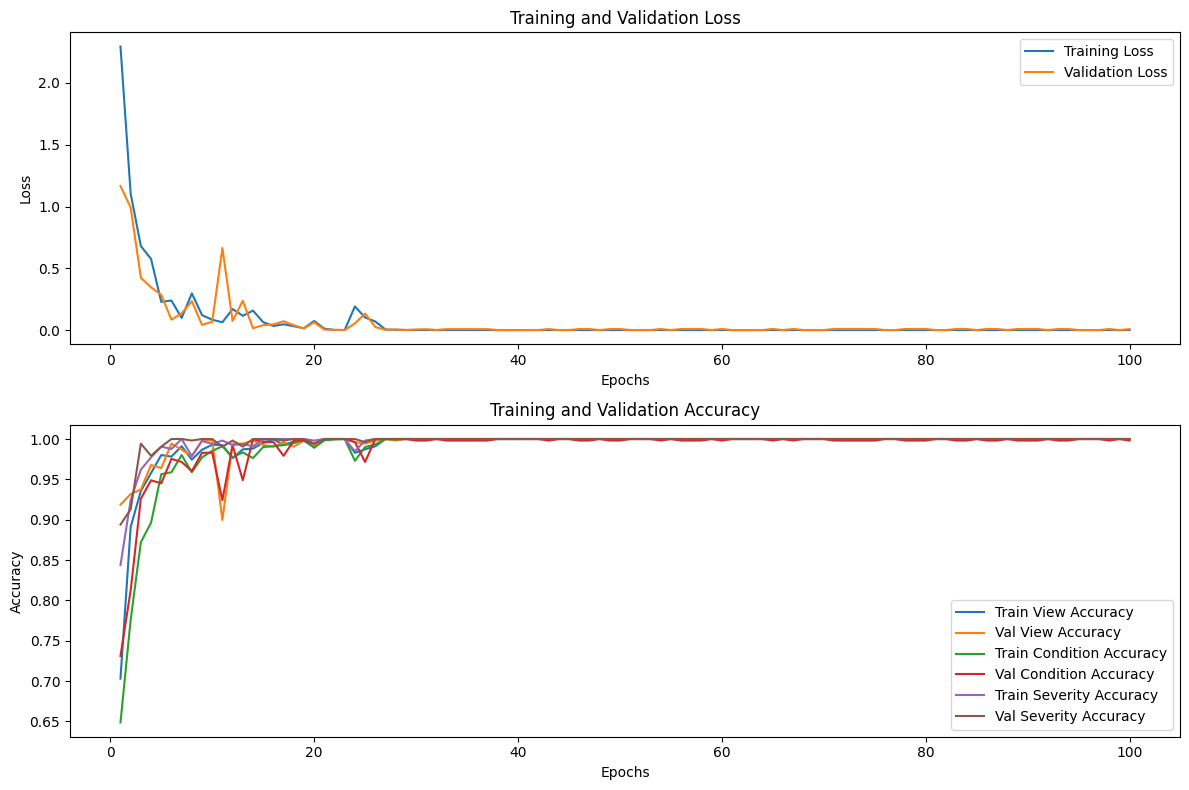

In [8]:
import matplotlib.pyplot as plt

# Number of unique classes:
# {'view': 3, 'condition': 7, 'severity': 3}
# View labels: ['Parasternal long axis (PLAX)' 'Parasternal short axis(PSAX)'
#  'Apical Four Chamber(A4C)']
# Condition labels: ['Not Applicable' 'Aortic Valve Regurgitation' 'Mitral Valve Prolapse'
#  'Aortic Valve Regurgitation, Pulmonary Valve Regurgitation'
#  'Tricuspid Valve Regurgitation' 'Pulmonary Valve Regurgitation'
#  'Mitral Valve Regurgitation']
# Severity labels: ['Not Applicable' 'Borderline rhd' 'Definite rhd']

# Define mappings from string labels to integers
view_label_mapping = {
    'Parasternal long axis (PLAX)': 0,
    'Parasternal short axis(PSAX)': 1,
    'Apical Four Chamber(A4C)': 2,
}

condition_label_mapping = {
    'Not Applicable': 0,
    'Aortic Valve Regurgitation': 1,
    'Mitral Valve Prolapse': 2,
    'Aortic Valve Regurgitation, Pulmonary Valve Regurgitation': 3,
    'Tricuspid Valve Regurgitation': 4,
    'Pulmonary Valve Regurgitation': 5,
    'Mitral Valve Regurgitation': 6
}

severity_label_mapping = {
    'Not Applicable': 0,
    'Borderline rhd': 1,
    'Definite rhd': 2
}

# Access the underlying dataset to get the number of classes
if isinstance(train_dataset, torch.utils.data.Subset):
    underlying_dataset = train_dataset.dataset
else:
    underlying_dataset = train_dataset

num_classes = underlying_dataset.num_classes

# Initialize the model
base_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
model = MultiTaskModel(base_model, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = {'view': [], 'condition': [], 'severity': []}
val_accuracies = {'view': [], 'condition': [], 'severity': []}

# Training loop
num_epochs = 100
scaler = GradScaler()
best_val_loss = float('inf')
early_stopping_patience = 5
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    view_correct = 0
    condition_correct = 0
    severity_correct = 0
    total_samples = 0

    for images, labels in train_dataloader:
        images = images.to(device)
        view_labels, condition_labels, severity_labels = labels

        # Map string labels to integers
        view_labels = [view_label_mapping[label] for label in view_labels]
        condition_labels = [condition_label_mapping[label] for label in condition_labels]
        severity_labels = [severity_label_mapping[label] for label in severity_labels]
        
        # Ensure labels are tensors and have the correct dimensions
        view_labels = torch.tensor(view_labels, dtype=torch.long).to(device)
        condition_labels = torch.tensor(condition_labels, dtype=torch.long).to(device)
        severity_labels = torch.tensor(severity_labels, dtype=torch.long).to(device)

        optimizer.zero_grad()
        with autocast():
            view_output, condition_output, severity_output = model(images)
            loss = combined_loss(view_output, condition_output, severity_output, view_labels, condition_labels, severity_labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        
        # Calculate accuracy
        view_correct += calculate_accuracy(view_output, view_labels) * len(view_labels)
        condition_correct += calculate_accuracy(condition_output, condition_labels) * len(condition_labels)
        severity_correct += calculate_accuracy(severity_output, severity_labels) * len(severity_labels)
        total_samples += len(view_labels)

    epoch_loss = running_loss / len(train_dataloader)
    view_accuracy = view_correct / total_samples
    condition_accuracy = condition_correct / total_samples
    severity_accuracy = severity_correct / total_samples

    train_losses.append(epoch_loss)
    train_accuracies['view'].append(view_accuracy)
    train_accuracies['condition'].append(condition_accuracy)
    train_accuracies['severity'].append(severity_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_view_correct = 0
    val_condition_correct = 0
    val_severity_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            view_labels, condition_labels, severity_labels = labels

            # Map string labels to integers
            view_labels = [view_label_mapping[label] for label in view_labels]
            condition_labels = [condition_label_mapping[label] for label in condition_labels]
            severity_labels = [severity_label_mapping[label] for label in severity_labels]
            
            # Ensure labels are tensors and have the correct dimensions
            view_labels = torch.tensor(view_labels, dtype=torch.long).to(device)
            condition_labels = torch.tensor(condition_labels, dtype=torch.long).to(device)
            severity_labels = torch.tensor(severity_labels, dtype=torch.long).to(device)

            view_output, condition_output, severity_output = model(images)
            loss = combined_loss(view_output, condition_output, severity_output, view_labels, condition_labels, severity_labels)

            val_running_loss += loss.item()
            
            # Calculate accuracy
            val_view_correct += calculate_accuracy(view_output, view_labels) * len(view_labels)
            val_condition_correct += calculate_accuracy(condition_output, condition_labels) * len(condition_labels)
            val_severity_correct += calculate_accuracy(severity_output, severity_labels) * len(severity_labels)
            val_total_samples += len(view_labels)

    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_view_accuracy = val_view_correct / val_total_samples
    val_condition_accuracy = val_condition_correct / val_total_samples
    val_severity_accuracy = val_severity_correct / val_total_samples

    val_losses.append(val_epoch_loss)
    val_accuracies['view'].append(val_view_accuracy)
    val_accuracies['condition'].append(val_condition_accuracy)
    val_accuracies['severity'].append(val_severity_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, '
          f'Train View Accuracy: {view_accuracy:.4f}, Val View Accuracy: {val_view_accuracy:.4f}, '
          f'Train Condition Accuracy: {condition_accuracy:.4f}, Val Condition Accuracy: {val_condition_accuracy:.4f}, '
          f'Train Severity Accuracy: {severity_accuracy:.4f}, Val Severity Accuracy: {val_severity_accuracy:.4f}')

    # Early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break


print('Finished Training')

# Plotting
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy for each task
plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracies['view'], label='Train View Accuracy')
plt.plot(epochs, val_accuracies['view'], label='Val View Accuracy')
plt.plot(epochs, train_accuracies['condition'], label='Train Condition Accuracy')
plt.plot(epochs, val_accuracies['condition'], label='Val Condition Accuracy')
plt.plot(epochs, train_accuracies['severity'], label='Train Severity Accuracy')
plt.plot(epochs, val_accuracies['severity'], label='Val Severity Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

            # Save the plot 
plt.savefig(
    'training_validation_plot.png', 
    dpi=330, 
    bbox_inches='tight', 
    format='png', 
    transparent=False, 
    pad_inches=0.1
)

plt.tight_layout()
plt.show()

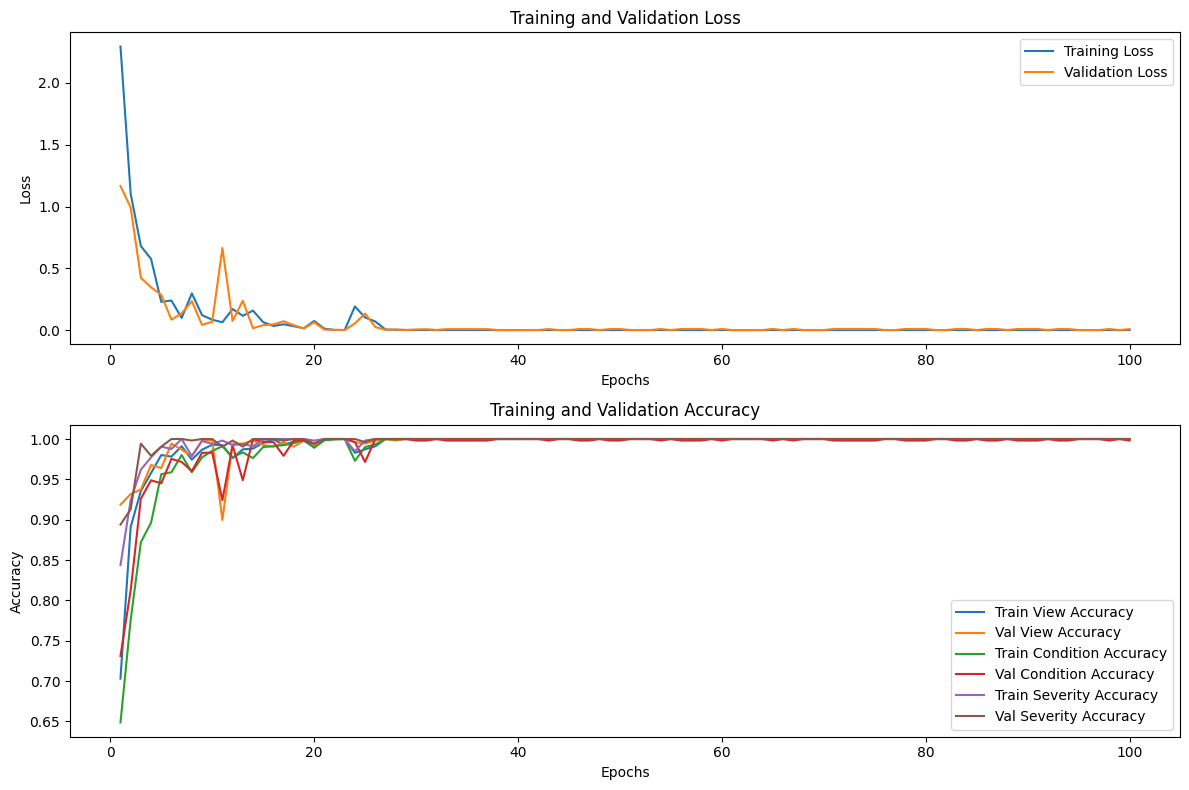

In [28]:
# # Plotting
# epochs = range(1, len(train_losses) + 1)

# plt.figure(figsize=(12, 8))

# # Plot training and validation loss
# plt.subplot(2, 1, 1)
# plt.plot(epochs, train_losses, label='Training Loss')
# plt.plot(epochs, val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss')

# # Plot training and validation accuracy for each task
# plt.subplot(2, 1, 2)
# plt.plot(epochs, train_accuracies['view'], label='Train View Accuracy')
# plt.plot(epochs, val_accuracies['view'], label='Val View Accuracy')
# plt.plot(epochs, train_accuracies['condition'], label='Train Condition Accuracy')
# plt.plot(epochs, val_accuracies['condition'], label='Val Condition Accuracy')
# plt.plot(epochs, train_accuracies['severity'], label='Train Severity Accuracy')
# plt.plot(epochs, val_accuracies['severity'], label='Val Severity Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training and Validation Accuracy')

#             # Save the plot 
# plt.savefig(
#     'training_validation_plot.png', 
#     dpi=330, 
#     bbox_inches='tight', 
#     format='png', 
#     transparent=False, 
#     pad_inches=0.1
# )

# plt.tight_layout()
# plt.show()

In [32]:
model

MultiTaskModel(
  (base_model): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
     

# Evaluation of Multi-Task Model Performance

This script evaluates the performance of a multi-task model on a validation dataset. It computes and displays classification reports and confusion matrices for each task (view, condition, and severity). Additionally, it visualizes the model's predictions on a subset of validation images.

## Key Steps:

1. **Import Libraries**: Import necessary libraries for metrics computation and visualization (`sklearn.metrics`, `matplotlib.pyplot`, and `torch`).

2. **Function to Compute and Display Metrics**:
    - `compute_and_display_metrics`: This function takes the true labels, predicted labels, label mapping, and task name as inputs. It computes the classification report and confusion matrix, and displays them using `matplotlib`.

3. **Collect Labels and Predictions**:
    - Initialize lists to store true labels and predictions for each task (view, condition, and severity).
    - Set the model to evaluation mode and iterate over the validation dataset.
    - For each batch, map string labels to integers, ensure labels are tensors, and make predictions using the model.
    - Store the true labels and predictions in the respective lists.

4. **Compute and Display Metrics for Each Task**:
    - Call `compute_and_display_metrics` for each task (view, condition, and severity) to display the classification report and confusion matrix.

5. **Visualize Predictions on Validation Images**:
    - Display a grid of 16 validation images along with their true and predicted labels for each task.
    - For each image, display the true and predicted labels for view, condition, and severity.
    - Use `matplotlib` to create a subplot grid and display the images with titles showing the true and predicted labels.

## Visualization Details:
- **Confusion Matrix**: Displays the confusion matrix for each task with class names on the axes.
- **Classification Report**: Shows precision, recall, and F1-score for each class.
- **Image Grid**: Displays a 4x4 grid of validation images with titles showing the true and predicted labels for each task.

This evaluation script provides a comprehensive overview of the model's performance on the validation dataset, helping to identify areas where the model performs well and where it may need improvement.

Classification Report for View:
                               precision    recall  f1-score   support

Parasternal long axis (PLAX)       1.00      1.00      1.00       132
Parasternal short axis(PSAX)       1.00      1.00      1.00       297
    Apical Four Chamber(A4C)       1.00      1.00      1.00        99

                    accuracy                           1.00       528
                   macro avg       1.00      1.00      1.00       528
                weighted avg       1.00      1.00      1.00       528



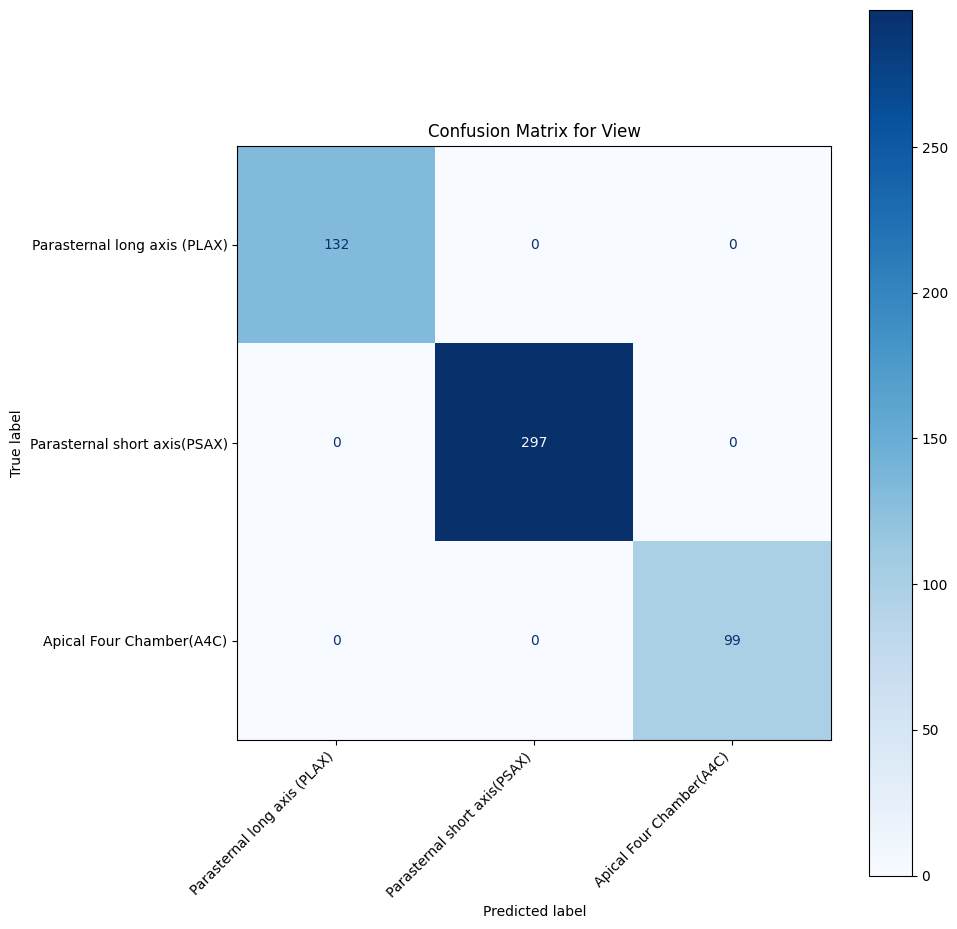

Classification Report for Condition:
                                                            precision    recall  f1-score   support

                                           Not Applicable       1.00      1.00      1.00       356
                               Aortic Valve Regurgitation       1.00      1.00      1.00        20
                                    Mitral Valve Prolapse       1.00      1.00      1.00        53
Aortic Valve Regurgitation, Pulmonary Valve Regurgitation       1.00      1.00      1.00        26
                            Tricuspid Valve Regurgitation       1.00      1.00      1.00        32
                            Pulmonary Valve Regurgitation       1.00      1.00      1.00        21
                               Mitral Valve Regurgitation       1.00      1.00      1.00        20

                                                 accuracy                           1.00       528
                                                macro avg       1.00 

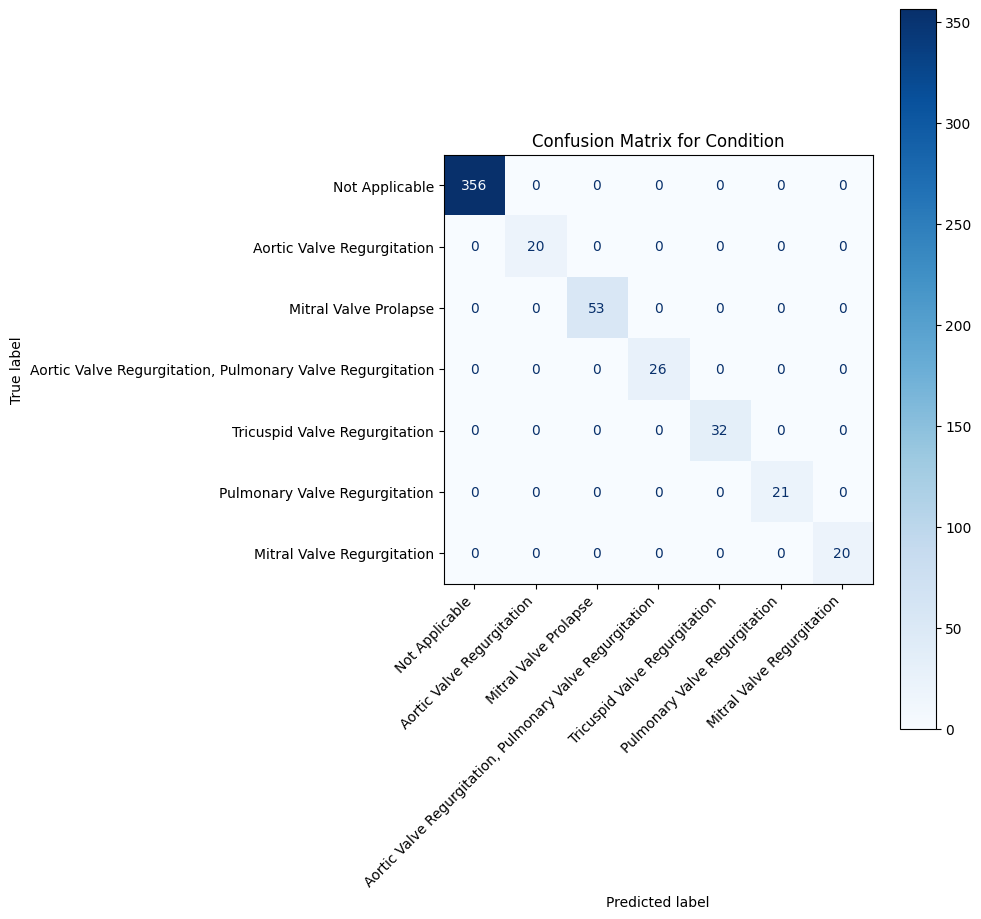

Classification Report for Severity:
                 precision    recall  f1-score   support

Not Applicable       1.00      1.00      1.00       440
Borderline rhd       1.00      1.00      1.00        46
  Definite rhd       1.00      1.00      1.00        42

      accuracy                           1.00       528
     macro avg       1.00      1.00      1.00       528
  weighted avg       1.00      1.00      1.00       528



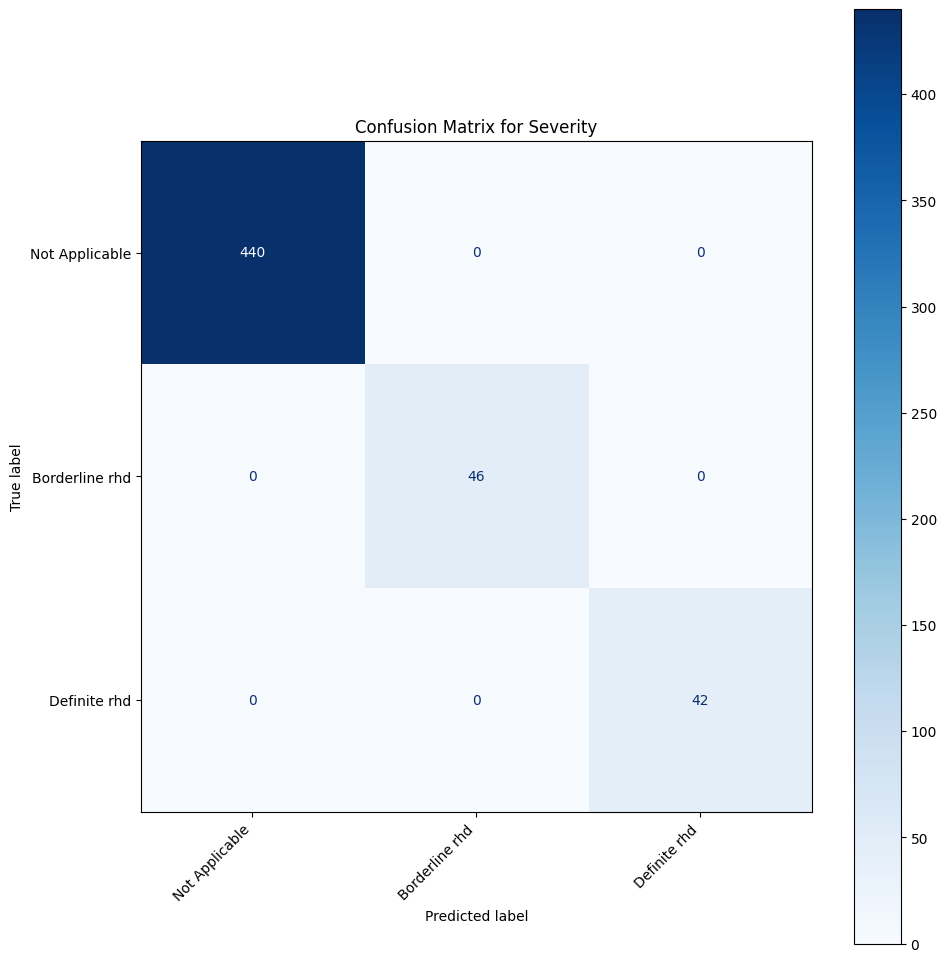

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

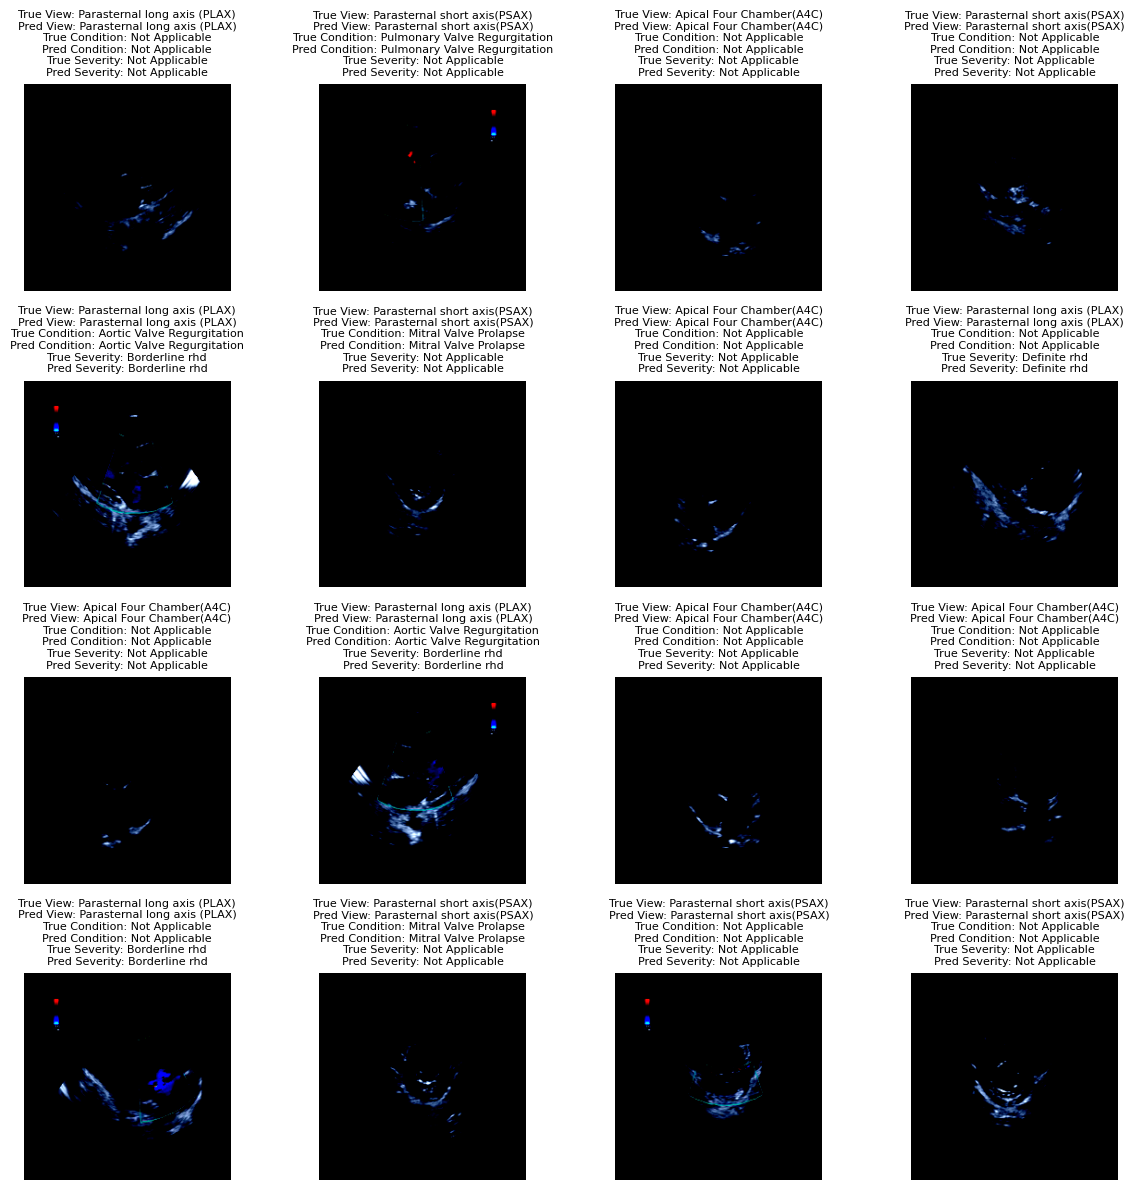

In [47]:
# Function to compute and display classification report and confusion matrix
def compute_and_display_metrics(all_labels, all_preds, label_mapping, task_name):
    class_names = list(label_mapping.keys())
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(f'Classification Report for {task_name}:\n', report)
    
    # Save classification report to a text file
    with open(f'{task_name}_classification_report.txt', 'w') as f:
        f.write(f'Classification Report for {task_name}:\n')
        f.write(report)
    
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size if necessary
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f'Confusion Matrix for {task_name}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
    plt.tight_layout()
    
    # Save confusion matrix plot to an image file
    plt.savefig(f'{task_name}_confusion_matrix.png', dpi=330, bbox_inches='tight', format='png', transparent=False, pad_inches=0.1)
    plt.show()


# Collect all labels and predictions for each task
all_view_labels = []
all_view_preds = []
all_condition_labels = []
all_condition_preds = []
all_severity_labels = []
all_severity_preds = []

model.eval()
with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to(device)
        view_labels, condition_labels, severity_labels = labels

        # Map string labels to integers
        view_labels = [view_label_mapping[label] for label in view_labels]
        condition_labels = [condition_label_mapping[label] for label in condition_labels]
        severity_labels = [severity_label_mapping[label] for label in severity_labels]
        
        # Ensure labels are tensors and have the correct dimensions
        view_labels = torch.tensor(view_labels, dtype=torch.long).to(device)
        condition_labels = torch.tensor(condition_labels, dtype=torch.long).to(device)
        severity_labels = torch.tensor(severity_labels, dtype=torch.long).to(device)

        view_output, condition_output, severity_output = model(images)
        
        _, view_preds = torch.max(view_output, 1)
        _, condition_preds = torch.max(condition_output, 1)
        _, severity_preds = torch.max(severity_output, 1)

        all_view_labels.extend(view_labels.cpu().numpy())
        all_view_preds.extend(view_preds.cpu().numpy())
        all_condition_labels.extend(condition_labels.cpu().numpy())
        all_condition_preds.extend(condition_preds.cpu().numpy())
        all_severity_labels.extend(severity_labels.cpu().numpy())
        all_severity_preds.extend(severity_preds.cpu().numpy())

# Compute and display metrics for each task
compute_and_display_metrics(all_view_labels, all_view_preds, view_label_mapping, 'View')
compute_and_display_metrics(all_condition_labels, all_condition_preds, condition_label_mapping, 'Condition')
compute_and_display_metrics(all_severity_labels, all_severity_preds, severity_label_mapping, 'Severity')

# Visualize predictions on validation images
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

image_count = 0
with torch.no_grad():
    for images, labels in val_dataloader:
        if image_count >= 16:  # Display only 16 images
            break
        images = images.to(device)
        view_labels, condition_labels, severity_labels = labels

        # Map string labels to integers
        view_labels = [view_label_mapping[label] for label in view_labels]
        condition_labels = [condition_label_mapping[label] for label in condition_labels]
        severity_labels = [severity_label_mapping[label] for label in severity_labels]
        
        # Ensure labels are tensors and have the correct dimensions
        view_labels = torch.tensor(view_labels, dtype=torch.long).to(device)
        condition_labels = torch.tensor(condition_labels, dtype=torch.long).to(device)
        severity_labels = torch.tensor(severity_labels, dtype=torch.long).to(device)

        view_output, condition_output, severity_output = model(images)
        
        _, view_preds = torch.max(view_output, 1)
        _, condition_preds = torch.max(condition_output, 1)
        _, severity_preds = torch.max(severity_output, 1)

        for j in range(images.size(0)):
            if image_count >= 16:
                break
            img = images[j].cpu().permute(1, 2, 0).numpy()
            true_view_label = list(view_label_mapping.keys())[list(view_label_mapping.values()).index(view_labels[j].cpu().numpy())]
            pred_view_label = list(view_label_mapping.keys())[list(view_label_mapping.values()).index(view_preds[j].cpu().numpy())]
            true_condition_label = list(condition_label_mapping.keys())[list(condition_label_mapping.values()).index(condition_labels[j].cpu().numpy())]
            pred_condition_label = list(condition_label_mapping.keys())[list(condition_label_mapping.values()).index(condition_preds[j].cpu().numpy())]
            true_severity_label = list(severity_label_mapping.keys())[list(severity_label_mapping.values()).index(severity_labels[j].cpu().numpy())]
            pred_severity_label = list(severity_label_mapping.keys())[list(severity_label_mapping.values()).index(severity_preds[j].cpu().numpy())]

            axes[image_count].imshow(img)
            axes[image_count].set_title(f'True View: {true_view_label}\nPred View: {pred_view_label}\n'
                                        f'True Condition: {true_condition_label}\nPred Condition: {pred_condition_label}\n'
                                        f'True Severity: {true_severity_label}\nPred Severity: {pred_severity_label}', fontsize=8)
            axes[image_count].axis('off')
            image_count += 1

plt.tight_layout()

# Save the visualization plot to an image file
plt.savefig('validation_predictions.png', dpi=330, bbox_inches='tight', format='png', transparent=False, pad_inches=0.1)

plt.show()

# Visualization of Model Embeddings using t-SNE and UMAP

This script visualizes the embeddings extracted from a multi-task model using t-SNE and UMAP. The embeddings are reduced to 2D space for visualization, and the labels for each task (view, condition, and severity) are used to color the points.

## Key Steps:

1. **Initialize Lists for Embeddings and Labels**:
    - Create lists to store embeddings and labels for each task (view, condition, and severity).

2. **Extract Embeddings and Labels**:
    - Set the model to evaluation mode and iterate over the validation dataset.
    - For each batch, map string labels to integers, ensure labels are tensors, and extract embeddings from the model.
    - Store the embeddings and labels in the respective lists.

3. **Concatenate Embeddings**:
    - Concatenate the embeddings from all batches into a single array.

4. **Dimensionality Reduction**:
    - Use t-SNE to reduce the dimensionality of the embeddings to 2D.
    - Use UMAP to reduce the dimensionality of the embeddings to 2D.

5. **Plot the Embeddings**:
    - Create a 2x3 grid of subplots using `matplotlib`.
    - Plot the 2D embeddings for each task (view, condition, and severity) using t-SNE and UMAP.
    - Color the points based on the labels and add legends to indicate the class names.

## Additional Step: Perform PCA before t-SNE and UMAP

To improve the performance and stability of t-SNE and UMAP, we can perform PCA to reduce the dimensionality of the embeddings before applying t-SNE and UMAP.


/home/lornamugambik/anaconda3/envs/venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/lornamugambik/anaconda3/envs/venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


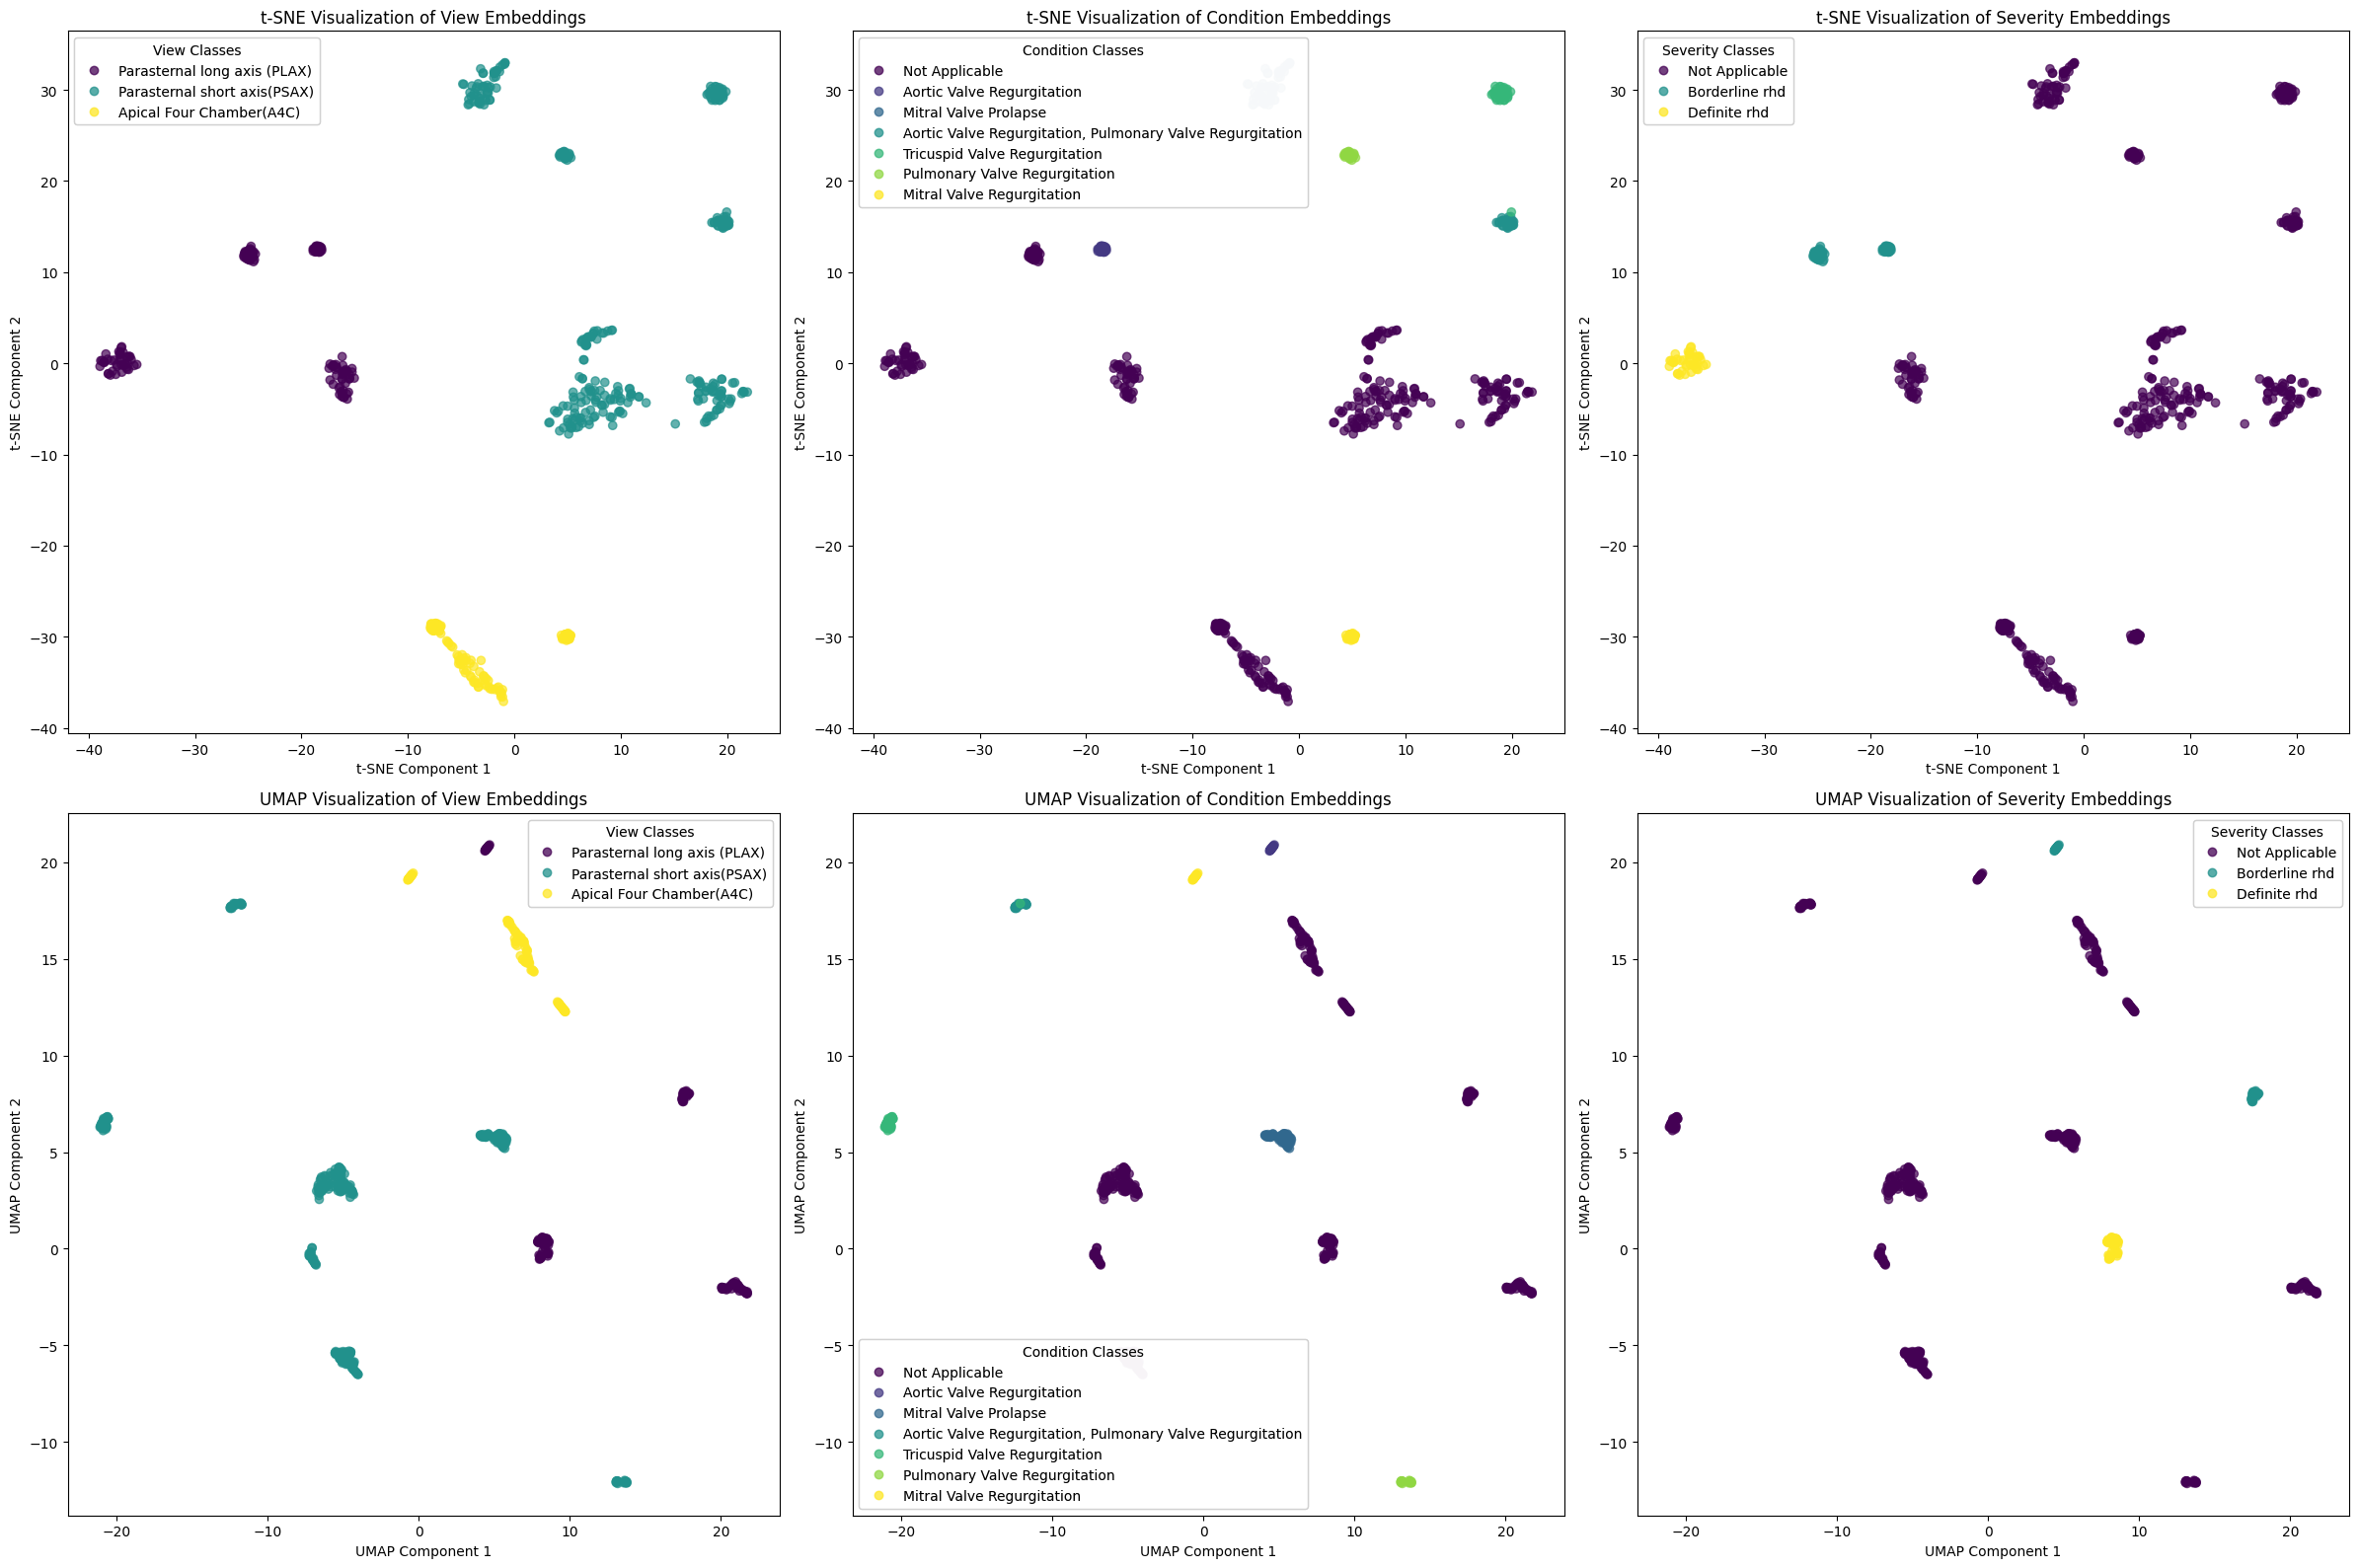

In [33]:
# Initialize lists to store embeddings and labels for each task
embeddings = []
view_labels = []
condition_labels = []
severity_labels = []

with torch.no_grad():
    for images, lbls in val_dataloader:
        images = images.to(device)
        
        # Extract labels from the tuple
        view_lbls, condition_lbls, severity_lbls = lbls
        
        # Map string labels to integers
        view_lbls = torch.tensor([view_label_mapping[label] for label in view_lbls]).to(device)
        condition_lbls = torch.tensor([condition_label_mapping[label] for label in condition_lbls]).to(device)
        severity_lbls = torch.tensor([severity_label_mapping[label] for label in severity_lbls]).to(device)
        
        # Extract embeddings from the model
        outputs = model.extract_features(images)
        
        # Assuming the embeddings are under the key 'x_norm_clstoken'
        embeddings.append(outputs.cpu().numpy())
        view_labels.extend(view_lbls.cpu().numpy())
        condition_labels.extend(condition_lbls.cpu().numpy())
        severity_labels.extend(severity_lbls.cpu().numpy())

# Concatenate embeddings
embeddings = np.concatenate(embeddings, axis=0)

# Perform PCA before t-SNE and UMAP
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Use t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d_tsne = tsne.fit_transform(embeddings_pca)

# Use UMAP to reduce dimensionality
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d_umap = umap_reducer.fit_transform(embeddings_pca)

# Plot the embeddings for each task using t-SNE and UMAP
fig, ax = plt.subplots(2, 3, figsize=(24, 16))

# Define class names for legends
view_class_names = ['Parasternal long axis (PLAX)', 'Parasternal short axis(PSAX)', 'Apical Four Chamber(A4C)']
condition_class_names = [
    'Not Applicable', 'Aortic Valve Regurgitation', 'Mitral Valve Prolapse',
    'Aortic Valve Regurgitation, Pulmonary Valve Regurgitation', 'Tricuspid Valve Regurgitation',
    'Pulmonary Valve Regurgitation', 'Mitral Valve Regurgitation'
]
severity_class_names = ['Not Applicable', 'Borderline rhd', 'Definite rhd']


# Plot for view labels using t-SNE
scatter = ax[0, 0].scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], c=view_labels, cmap='viridis', alpha=0.7)
legend1 = ax[0, 0].legend(handles=scatter.legend_elements()[0], labels=view_class_names, title="View Classes")
ax[0, 0].add_artist(legend1)
ax[0, 0].set_title('t-SNE Visualization of View Embeddings')
ax[0, 0].set_xlabel('t-SNE Component 1')
ax[0, 0].set_ylabel('t-SNE Component 2')

# Plot for condition labels using t-SNE
scatter = ax[0, 1].scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], c=condition_labels, cmap='viridis', alpha=0.7)
legend2 = ax[0, 1].legend(handles=scatter.legend_elements()[0], labels=condition_class_names, title="Condition Classes")
ax[0, 1].add_artist(legend2)
ax[0, 1].set_title('t-SNE Visualization of Condition Embeddings')
ax[0, 1].set_xlabel('t-SNE Component 1')
ax[0, 1].set_ylabel('t-SNE Component 2')

# Plot for severity labels using t-SNE
scatter = ax[0, 2].scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], c=severity_labels, cmap='viridis', alpha=0.7)
legend3 = ax[0, 2].legend(handles=scatter.legend_elements()[0], labels=severity_class_names, title="Severity Classes")
ax[0, 2].add_artist(legend3)
ax[0, 2].set_title('t-SNE Visualization of Severity Embeddings')
ax[0, 2].set_xlabel('t-SNE Component 1')
ax[0, 2].set_ylabel('t-SNE Component 2')

# Plot for view labels using UMAP
scatter = ax[1, 0].scatter(embeddings_2d_umap[:, 0], embeddings_2d_umap[:, 1], c=view_labels, cmap='viridis', alpha=0.7)
legend4 = ax[1, 0].legend(handles=scatter.legend_elements()[0], labels=view_class_names, title="View Classes")
ax[1, 0].add_artist(legend4)
ax[1, 0].set_title('UMAP Visualization of View Embeddings')
ax[1, 0].set_xlabel('UMAP Component 1')
ax[1, 0].set_ylabel('UMAP Component 2')

# Plot for condition labels using UMAP
scatter = ax[1, 1].scatter(embeddings_2d_umap[:, 0], embeddings_2d_umap[:, 1], c=condition_labels, cmap='viridis', alpha=0.7)
legend5 = ax[1, 1].legend(handles=scatter.legend_elements()[0], labels=condition_class_names, title="Condition Classes")
ax[1, 1].add_artist(legend5)
ax[1, 1].set_title('UMAP Visualization of Condition Embeddings')
ax[1, 1].set_xlabel('UMAP Component 1')
ax[1, 1].set_ylabel('UMAP Component 2')

# Plot for severity labels using UMAP
scatter = ax[1, 2].scatter(embeddings_2d_umap[:, 0], embeddings_2d_umap[:, 1], c=severity_labels, cmap='viridis', alpha=0.7)
legend6 = ax[1, 2].legend(handles=scatter.legend_elements()[0], labels=severity_class_names, title="Severity Classes")
ax[1, 2].add_artist(legend6)
ax[1, 2].set_title('UMAP Visualization of Severity Embeddings')
ax[1, 2].set_xlabel('UMAP Component 1')
ax[1, 2].set_ylabel('UMAP Component 2')

plt.tight_layout()

plt.savefig(
    'visualized_clusters_plot.png', 
    dpi=330, 
    bbox_inches='tight', 
    format='png', 
    transparent=False, 
    pad_inches=0.1
)

plt.show()

Silhouette Score: 0.4176
Cluster distribution for labeled images:
[1143  588  381]
Cluster distribution for unlabeled images:
[55  9 36]


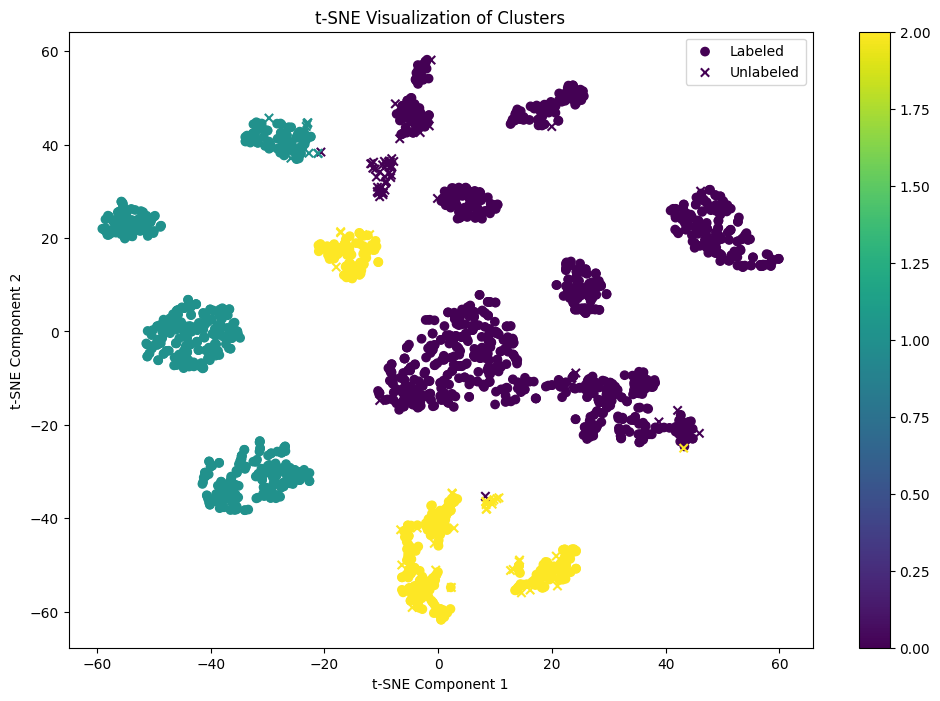

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract embeddings for labeled and unlabeled images
def extract_embeddings(dataloader, model):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            
            images = images.to(device)
            features = model.extract_features(images)
            embeddings.append(features.cpu().numpy())
    return np.concatenate(embeddings, axis=0)

# Extract embeddings for labeled images
labeled_embeddings = extract_embeddings(train_dataloader, model)

# Extract embeddings for unlabeled images
unlabeled_embeddings = extract_embeddings(unlabelled_dataloader, model)

# Combine embeddings
all_embeddings = np.concatenate([labeled_embeddings, unlabeled_embeddings], axis=0)

# Perform clustering
num_clusters = 3  # Adjust the number of clusters as needed
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)
cluster_labels = agg_clustering.fit_predict(all_embeddings)

# Evaluate cluster consistency using silhouette score
silhouette_avg = silhouette_score(all_embeddings, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.4f}')

# Analyze cluster distribution
labeled_cluster_labels = cluster_labels[:len(labeled_embeddings)]
unlabeled_cluster_labels = cluster_labels[len(labeled_embeddings):]

# Print cluster distribution for labeled images
print("Cluster distribution for labeled images:")
print(np.bincount(labeled_cluster_labels))

# Print cluster distribution for unlabeled images
print("Cluster distribution for unlabeled images:")
print(np.bincount(unlabeled_cluster_labels))


# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
all_embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot the clusters
plt.figure(figsize=(12, 8))
plt.scatter(all_embeddings_2d[:len(labeled_embeddings), 0], all_embeddings_2d[:len(labeled_embeddings), 1], c=labeled_cluster_labels, cmap='viridis', marker='o', label='Labeled')
plt.scatter(all_embeddings_2d[len(labeled_embeddings):, 0], all_embeddings_2d[len(labeled_embeddings):, 1], c=unlabeled_cluster_labels, cmap='viridis', marker='x', label='Unlabeled')
#plt.colorbar()
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.savefig('all_cluster_visualization.png', dpi=330, bbox_inches='tight', format='png', transparent=False, pad_inches=0.1)
plt.show()

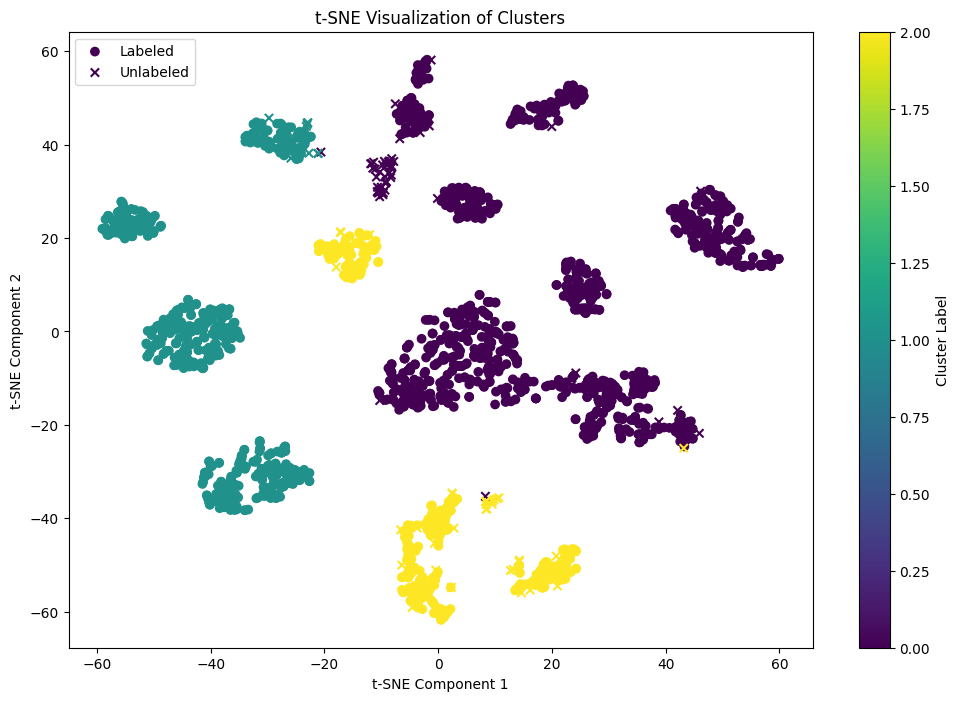

In [41]:
# Plot the clusters
plt.figure(figsize=(12, 8))

# Plot labeled embeddings
scatter_labeled = plt.scatter(
    all_embeddings_2d[:len(labeled_embeddings), 0], 
    all_embeddings_2d[:len(labeled_embeddings), 1], 
    c=labeled_cluster_labels, 
    cmap='viridis', 
    marker='o', 
    label='Labeled'
)

# Plot unlabeled embeddings
scatter_unlabeled = plt.scatter(
    all_embeddings_2d[len(labeled_embeddings):, 0], 
    all_embeddings_2d[len(labeled_embeddings):, 1], 
    c=unlabeled_cluster_labels, 
    cmap='viridis', 
    marker='x', 
    label='Unlabeled'
)

# Add colorbar
cbar = plt.colorbar(scatter_labeled, label='Cluster Label')

# Create custom legend for cluster colors
cluster_legend_labels = ['View Classes', 'Condition Classes', 'Severity Classes']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cbar.cmap(cbar.norm(i)), markersize=10) for i in range(num_clusters)]
plt.legend(handles, cluster_legend_labels, title="Clusters", loc="upper right")


# Add title and labels
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add legend for labeled and unlabeled markers
plt.legend(loc='upper left')

# Save the plot
plt.savefig('all_cluster_visualization.png', dpi=330, bbox_inches='tight', format='png', transparent=False, pad_inches=0.1)

# Show the plot
plt.show()

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Apply K-Means clustering
num_clusters = 3  # You can choose the number of clusters based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
unlabeled_clusters = kmeans.fit_predict(unlabeled_embeddings)

# Calculate silhouette score to evaluate the clustering
sil_score = silhouette_score(unlabeled_embeddings, unlabeled_clusters)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.30248725414276123


100


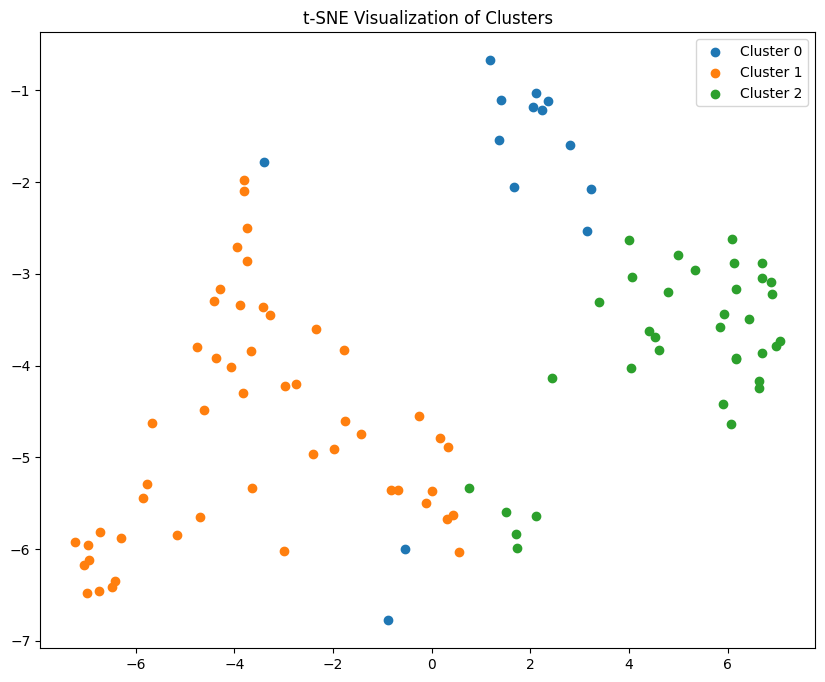

In [45]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
unlabeled_features_2d = tsne.fit_transform(unlabeled_embeddings)
print(len(unlabeled_embeddings))

# Plot the clusters
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_points = unlabeled_features_2d[unlabeled_clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
plt.legend()
plt.title('t-SNE Visualization of Clusters')
plt.show()

In [46]:
# Assign pseudo-labels to the unlabeled data
unlabeled_data_pseudo_labels = unlabeled_cluster_labels
print("Pseudo-labels assigned to unlabeled data:", unlabeled_data_pseudo_labels)

Pseudo-labels assigned to unlabeled data: [0 1 2 2 0 0 0 2 0 2 1 0 0 2 0 0 2 0 1 0 2 0 0 2 2 2 2 2 0 0 0 1 2 0 0 0 0
 0 2 2 2 0 0 0 0 2 1 2 0 0 0 2 0 0 2 2 0 2 0 0 1 0 0 2 0 0 0 2 2 0 2 0 0 1
 0 0 0 2 2 2 2 0 0 0 0 2 2 2 0 1 0 2 0 0 2 0 0 0 1 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


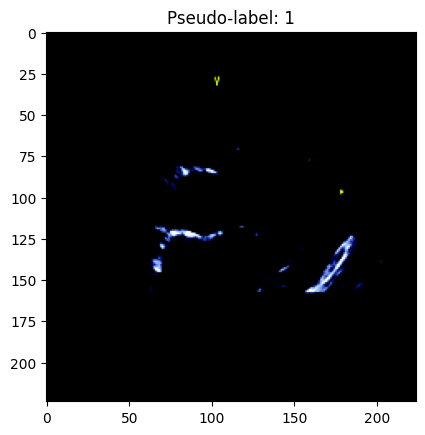

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


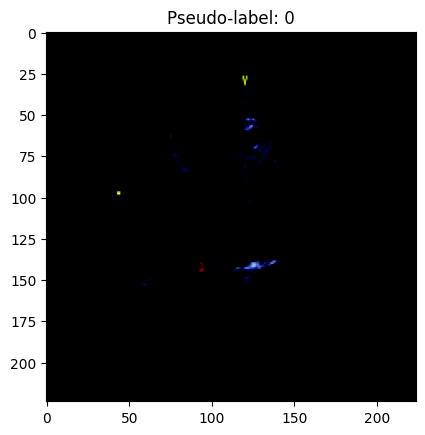

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


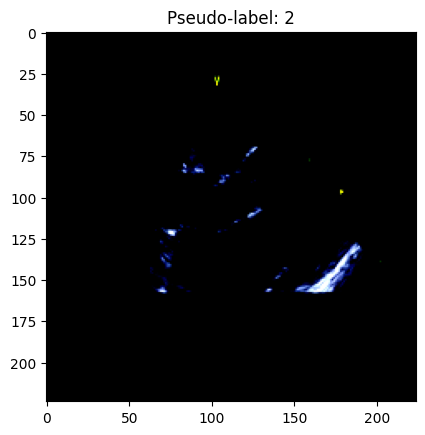

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


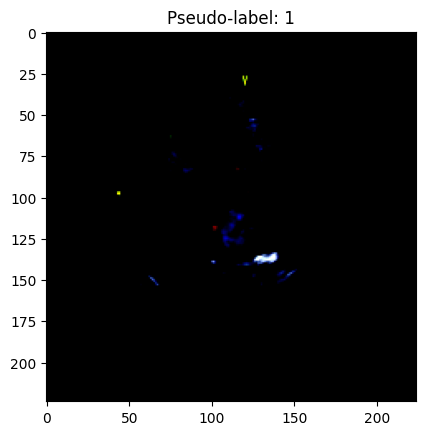

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


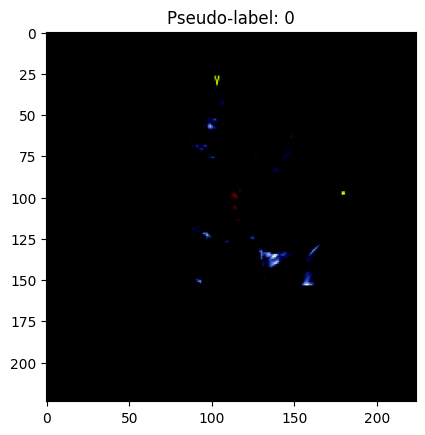

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


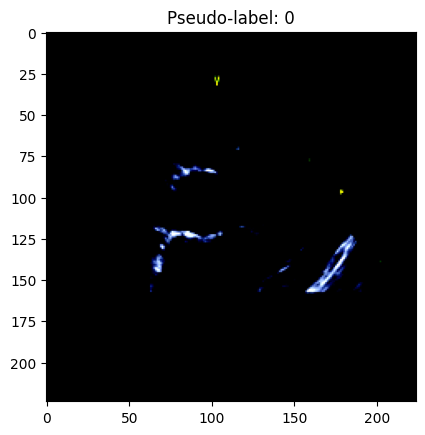

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


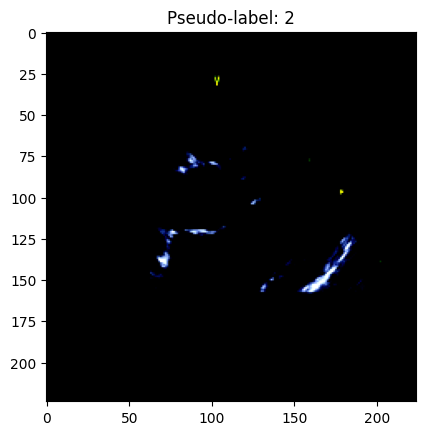

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


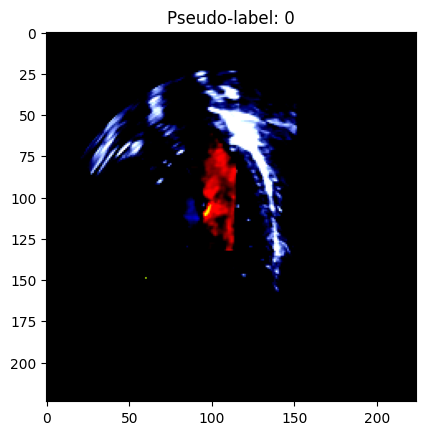

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


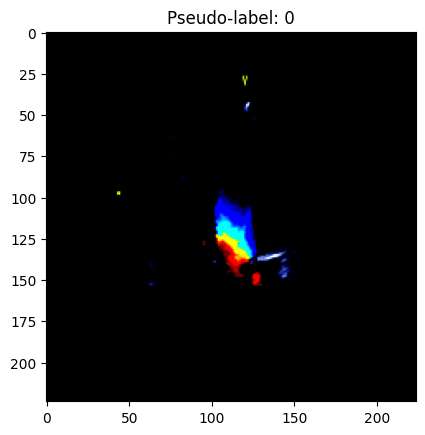

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


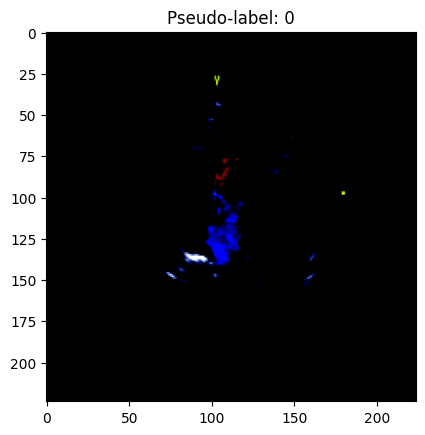

In [13]:
# Select a subset of pseudo-labeled data for human evaluation
subset_indices = np.random.choice(len(unlabeled_embeddings), size=10, replace=False)
subset_images = [unlabelled_dataset[i] for i in subset_indices]
subset_pseudo_labels = [unlabeled_data_pseudo_labels[i] for i in subset_indices]

# Display the subset images and their pseudo-labels for human evaluation
for i, (data, label) in enumerate(zip(subset_images, subset_pseudo_labels)):
    if isinstance(data, tuple):
        image = data[0]
    else:
        image = data
    plt.figure()
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())  # Assuming images are in PyTorch tensor format
    plt.title(f"Pseudo-label: {label}")
    plt.show()

In [14]:
# Calculate distances to cluster centers (using the mean of each cluster as the center)
cluster_centers = np.array([all_embeddings[cluster_labels == i].mean(axis=0) for i in range(num_clusters)])
closest, distances = pairwise_distances_argmin_min(all_embeddings, cluster_centers)

# Normalize distances to get confidence scores (higher score means higher confidence)
confidence_scores = 1 - (distances / np.max(distances))

# Assign confidence scores to the unlabeled data
unlabeled_data_confidence_scores = confidence_scores[len(labeled_embeddings):]
print("Confidence scores for unlabeled data:", unlabeled_data_confidence_scores)
print(len(unlabeled_data_confidence_scores))

Confidence scores for unlabeled data: [0.13304842 0.07760151 0.76147597 0.81193827 0.26726803 0.05302989
 0.19176547 0.81219819 0.23584812 0.75389332 0.09185525 0.21744365
 0.14713389 0.29201731 0.27468704 0.61068621 0.5362825  0.30569257
 0.11697228 0.18164832 0.51987495 0.19793585 0.21975458 0.58372656
 0.75202535 0.76116065 0.39737584 0.39836023 0.64719342 0.64012645
 0.2071122  0.         0.75347983 0.24852821 0.31631583 0.43445386
 0.08884645 0.6183863  0.46477154 0.45082993 0.69428141 0.25531987
 0.1328957  0.04085876 0.22299944 0.78010025 0.11315694 0.55267828
 0.2604173  0.39529541 0.32509764 0.77542    0.34643565 0.22008073
 0.30125807 0.28262541 0.2794533  0.75492052 0.0891249  0.18401759
 0.07107005 0.44238442 0.36296758 0.78323963 0.17127361 0.23698583
 0.24266697 0.7872043  0.55121905 0.29710674 0.74602457 0.64539667
 0.06038322 0.02872435 0.22169003 0.21847665 0.27424766 0.77327139
 0.66403493 0.74381867 0.77800072 0.67373492 0.69472241 0.20137266
 0.31213652 0.7487061  0

In [15]:
# Example: Check if the distribution of pseudo-labels matches the known distribution of true labels
def check_consistency_with_known_patterns(true_labels, pseudo_labels):
    true_labels = np.array(true_labels)
    pseudo_labels = np.array(pseudo_labels)
    max_label = max(true_labels.max(), pseudo_labels.max()) + 1
    true_label_distribution = np.bincount(true_labels, minlength=max_label) / len(true_labels)
    pseudo_label_distribution = np.bincount(pseudo_labels, minlength=max_label) / len(pseudo_labels)
    consistency_score = np.sum(np.minimum(true_label_distribution, pseudo_label_distribution))
    return consistency_score

# Assuming `view_labels`, `condition_labels`, and `severity_labels` are the true labels for labeled data
view_consistency = check_consistency_with_known_patterns(view_labels, labeled_cluster_labels)
condition_consistency = check_consistency_with_known_patterns(condition_labels, labeled_cluster_labels)
severity_consistency = check_consistency_with_known_patterns(severity_labels, labeled_cluster_labels)

print(f"View Consistency: {view_consistency}")
print(f"Condition Consistency: {condition_consistency}")
print(f"Severity Consistency: {severity_consistency}")

View Consistency: 0.7088068181818181
Condition Consistency: 0.6794507575757575
Severity Consistency: 0.7078598484848485
